In [13]:
# Import modules
from __future__ import print_function
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('Using GPU(0):', physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
else:
    print('Using CPU')

import numpy as np
from numpy.random import shuffle
import time
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline

# Notebook auto reload code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2
print(tf.__version__)

Using GPU(0): PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.4.0


In [14]:
import tensorflow as tf
import os
import shutil

data_dir = "tiny-imagenet-10"  # Folder name after extraction

# Get the list of all class directories in the training set
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [15]:
import shutil

# Define preprocessing
IMG_SIZE = 224  # Resize all images to 224x224
BATCH_SIZE = 8

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',  # Labels are integers
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


Found 5000 files belonging to 10 classes.


In [16]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Test Dataset (if test labels exist)
# If no labels, use label_mode=None
try:
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        label_mode=None,  # Set None if labels are not available
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=False
    ).map(lambda x: tf.image.resize(x, [IMG_SIZE, IMG_SIZE]) / 255.0, 
          num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
except Exception as e:
    test_ds = None
    print(f"No test dataset found: {e}")

# Check dataset shapes
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)
for images, labels in val_ds.take(1):
    print("Validation batch shape:", images.shape, labels.shape)

if test_ds:
    for images in test_ds.take(1):
        print("Test batch shape:", images.shape)

Found 500 files belonging to 10 classes.
No test dataset found: name 'test_dir' is not defined
Train batch shape: (8, 224, 224, 3) (8,)
Validation batch shape: (8, 224, 224, 3) (8,)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same"),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    # Build the model
    return Sequential(layers_list)

In [ ]:
from utils.ConvMixer import ConvMixer
# Model parameters
dim = 512
depth = 8
kernel_size = 9
patch_size = 7
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 512)       75776     
_________________________________________________________________
activation_68 (Activation)   (None, 32, 32, 512)       0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 32, 32, 512)       2048      
_________________________________________________________________
sequential_69 (Sequential)   (None, 32, 32, 512)       308736    
_________________________________________________________________
sequential_71 (Sequential)   (None, 32, 32, 512)       308736    
_________________________________________________________________
sequential_73 (Sequential)   (None, 32, 32, 512)       308736    
_________________________________________________________________
sequential_75 (Sequential)   (None, 32, 32, 512)     

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [28]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")

In [29]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 218s 342ms/step - loss: 2.2192 - sparse_categorical_accuracy: 0.2400 - val_loss: 2.2747 - val_sparse_categorical_accuracy: 0.3380
Epoch 1 time: 218.15 seconds
Epoch 2/15
625/625 [==============================] - 213s 341ms/step - loss: 1.7381 - sparse_categorical_accuracy: 0.4050 - val_loss: 1.9759 - val_sparse_categorical_accuracy: 0.4220
Epoch 2 time: 213.27 seconds
Epoch 3/15
625/625 [==============================] - 214s 342ms/step - loss: 1.5401 - sparse_categorical_accuracy: 0.4784 - val_loss: 1.6201 - val_sparse_categorical_accuracy: 0.4900
Epoch 3 time: 213.54 seconds
Epoch 4/15
625/625 [==============================] - 214s 342ms/step - loss: 1.3720 - sparse_categorical_accuracy: 0.5353 - val_loss: 1.4409 - val_sparse_categorical_accuracy: 0.5280
Epoch 4 time: 214.07 seconds
Epoch 5/15
625/625 [==============================] - 213s 341ms/step - loss: 1.2401 - sparse_categorical_accuracy: 0.5815 - val_loss: 1.4992 - val_

In [30]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 6s 89ms/step - loss: 1.4348 - sparse_categorical_accuracy: 0.6760
Validation Loss: 1.4348
Validation Accuracy: 67.6000%


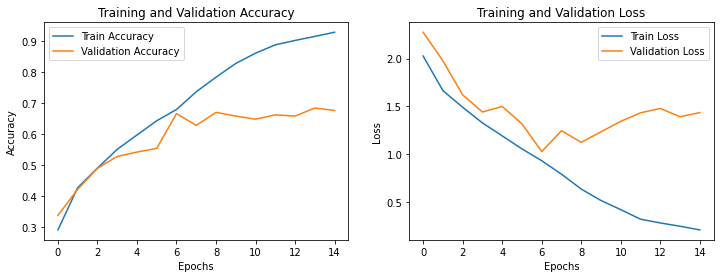

In [31]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()